In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('/content/mergedData.csv')

In [ ]:
df.head()

,text,label
0,nigerian soldier battle boko haram kill r...,1
1,noah green capitol attacker supporter natio...,1
2,year ago tweet outed raid osama bin laden,1
3,terrorist attack austria,1
4,soldier receives medal honor helping save c...,1


In [ ]:
text = df['text']
label = df['label']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [ ]:
sequence = tokenizer.texts_to_sequences(text)
padded_sequence = pad_sequences(sequence,padding='post')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequence,label,test_size=0.3,shuffle=True,random_state = 42)

In [ ]:
embeddings_index = {};
with open('/content/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size,100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
model = Sequential()

model.add(Embedding(vocab_size,100,weights=[embeddings_matrix],trainable=False))
model.add(Bidirectional(LSTM(32,return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         993900    
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         34048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,054,893
Trainable params: 60,993
Non-tra

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
118/118 [==============================] - 63s 431ms/step - loss: 0.2878 - accuracy: 0.8736 - val_loss: 0.1929 - val_accuracy: 0.9153
Epoch 2/10
118/118 [==============================] - 48s 409ms/step - loss: 0.1547 - accuracy: 0.9375 - val_loss: 0.1779 - val_accuracy: 0.9258
Epoch 3/10
118/118 [==============================] - 48s 409ms/step - loss: 0.1346 - accuracy: 0.9425 - val_loss: 0.1646 - val_accuracy: 0.9283
Epoch 4/10
118/118 [==============================] - 48s 408ms/step - loss: 0.1175 - accuracy: 0.9512 - val_loss: 0.1737 - val_accuracy: 0.9333
Epoch 5/10
118/118 [==============================] - 48s 408ms/step - loss: 0.1093 - accuracy: 0.9536 - val_loss: 0.1567 - val_accuracy: 0.9357
Epoch 6/10
118/118 [==============================] - 48s 410ms/step - loss: 0.0935 - accuracy: 0.9637 - val_loss: 0.1712 - val_accuracy: 0.9265
Epoch 7/10
118/118 [==============================] - 48s 408ms/step - loss: 0.0955 - accuracy: 0.9608 - val_loss: 0.1746 - val_ac

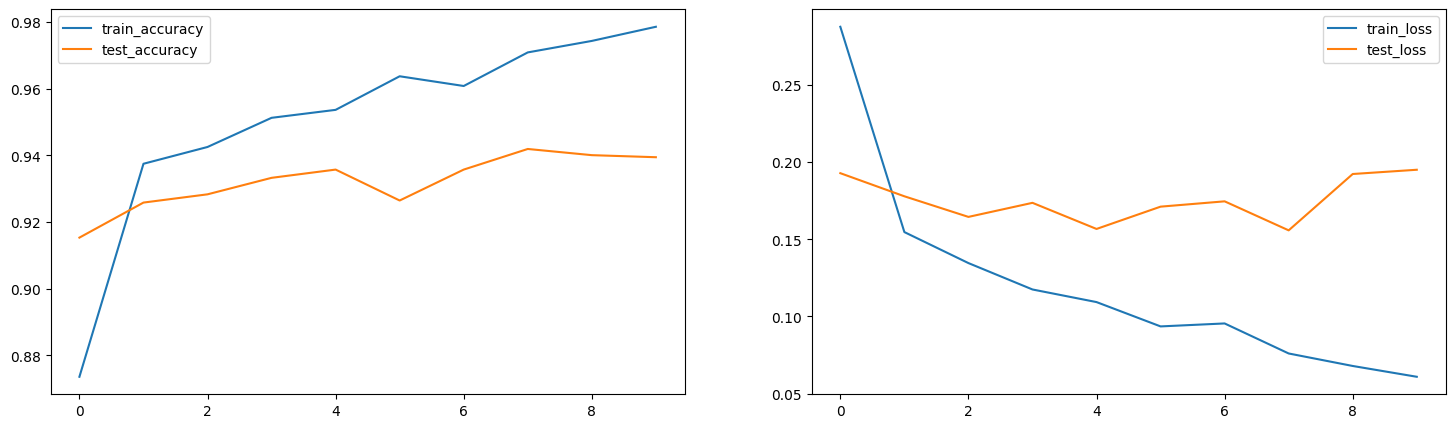

In [ ]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(18,5))
ax1.plot(history.history['accuracy'],label='train_accuracy')
ax1.plot(history.history['val_accuracy'],label='test_accuracy')
ax1.legend()
ax2.plot(history.history['loss'],label='train_loss')
ax2.plot(history.history['val_loss'],label='test_loss')
ax2.legend()
plt.show()


In [ ]:
model.evaluate(x_test,y_test)

51/51 [==============================] - 8s 146ms/step - loss: 0.1951 - accuracy: 0.9394


[0.19512015581130981, 0.939431369304657]

In [ ]:
model.save('./lstm.h5')

In [ ]:
pred = model.predict(x_test)

51/51 [==============================] - 10s 164ms/step


In [ ]:
pred = pred>0.5

In [ ]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

       False       0.84      0.91      0.87       368
        True       0.97      0.95      0.96      1250

    accuracy                           0.94      1618
   macro avg       0.90      0.93      0.92      1618
weighted avg       0.94      0.94      0.94      1618

